In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf

import rdatasets

# Chap 8. 로지스틱 회귀분석과 포아송 회귀분석
- 선형회귀분석 : 결과변수는 연속형 정규분포여야 함
    - 실제로는 결과변수가 범주형, 횟수 일 수 있고, 정규분포를 따르지 않음
    $$\mu_y = \beta_0 + \beta_1x_1 + \beta_2x_2 + \dots + \beta_mx_m$$
    - 결과변수의 조건부 평균은 예측변수들의 선형결합. 예측변수가 주어졌ㅇ르 때 결과변수 $\hat{y}$를 추정(예측변수들이 사전에 주어졌을 때 y 분포의 평균
- 일반선형모델 : 정규분포를 따르지 않는 결과변수를 수용할 수 있는 일반화된 회귀 모델
$$f(\mu_y) = \beta_0 + \beta_1x_1 + \dots + \beta_mx_m$$
    - $f(\mu_y)$ : 조건부 평균의 함수(링크함수), 다른 확률분포를 따르는 것으로 가정할 수 있음
    - 링크함수와 확률분포를 지정함으로써 다양한 확장된 선형회귀모델 생성
- 로지스틱 회귀모델
$$ln(\frac{p}{1-p})=\beta_0+\beta_1x_1+\dots+\beta_mx_m$$
    - 결과변수 : 범주형변수 / 확률분포 : 이항분포
- 포아송회귀모델
$$ln(\lambda)=\beta_0+\beta_1x_1+\dots+\beta_mx_m$$
    - 결과변수 : 횟수변수  /  확률분포 : 포아송분포  / $\lambda$: y의 평균
    
## 8-2 이항 로지스틱 회귀분석
- 종속변수가 이분형 범주일 때 독립변수로부터 결과변수 범주 예측
$$ln(\frac{p}{1-p})=\beta_0+\beta_1x_1+\dots+\beta_mx_m$$
    - 특정 사건이 발생할 확률을 직접 추정 : 결과 변수 예측값은 항상 [0,1], 기준값 기준 대소 비교
    - 결과변수 : 범주형변수 / 확률분포 : 이항분포
$$사건발생확률\ p=\frac{e^z}{1+e^z}=\frac{1}{1+e^{-z}},\quad z=\beta_0+\beta_1x_1+\dots+\beta_mx_m$$
    - 예측변수와 결과변수는 S자의 비선형관계를 가지며, p=0.5에서 기울기가 급해짐
- 로그오즈
    - 오즈 :$\frac{p}{1-p}$, 사건이 발생할 가능성이 그렇지 않을 가능성의 배수
    - 로지스틱 회귀모델은 로그오즈에 대한 선형회귀모델 정의
- 오즈비 : 독립변수 한 단위 증가에 따른 오즈(사건발생확률 대 미발생확률 비율)의 변화비율
    $오즈=\frac{P(사건발생)}{P(사건미발생)} = e^z = e^{\beta_0+\sum \beta_ix_i}$
    - 계수가 3인 경우, 2가 증가하면 3^2=9배 확률 증가
    
### 로지스틱 회귀모델의 유의성 검정    
- deviance : 이탈 => 모델의 비 적합도, 값이 작으면 모델이 데이터를 잘 설명한다는 것
    - residual deviance : 예측변수가 모두 포함 된 모델의 이탈도 => 충분한 이탈도의 감소인지 검정 => 카이스퀘어 검정
    - null deviance와 residual deviance의 차이가 0인지 검정, 두 이탈도의 차이가 0이 아니라면 예측변수가 추가된 현 모델이 데이터를 잘 적합시키며 통계적으로 유의한 모델이라는 결론
    - null & residual deviance의 차이는 null model과 residual model의 모수 개수 차이를 자유도로 갖는 카이제곱분포 따름
        - 관측값 n, 제안모델 예측변수 p : df_null = n-1. / df_resid = n-(p+1)
    - 두 deviance의 차아ㅣ를 $\chi^2$ 검정통계량으로 사용하여 카이제곱 검정 수행
- 과산포 : 결과변수의 실체 관측된 분산이 이항분포로부터 기대되는 분산보다 더 큰 경우
    => 표준오차를 왜곡시켜 표준오차의 유의성 검증을 부정확하게 함, glm에서 family를 quasibinomial 사용해줘야 함
    - 과산포 확인 : 
    1) 이항분포 로지스틱회귀모델에서 이탈도와 자유도 간 비율 확인 => 1보다 클 경우 과산포 의심
    2) quasi binomimal과 binomial 두 분포 모델의 검정통계량을 chi2 분포상에서 검정
        - H0: '과산포 비율이 1'
        - p가 유의수준을 만족하면, null & residual deviance 차이는 0이 아니며, null model에 비해 residual model이 데이터를 더 잘 설명해준다는 의미
        
## 8.3 페널티 로지스틱 회귀분석
- 너무 많은 변수가 추가될 경우, 페널티 부과        

In [95]:
churn = pd.read_csv("../data/kwak/mlc_churn.csv", index_col=0).reset_index(drop=True)
churn.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,KS,128,area_code_415,no,yes,25,265.10000,110,45.07000,197.40000,99,16.78000,244.70000,91,11.01000,10.00000,3,2.70000,1,no
1,OH,107,area_code_415,no,yes,26,161.60000,123,27.47000,195.50000,103,16.62000,254.40000,103,11.45000,13.70000,3,3.70000,1,no
2,NJ,137,area_code_415,no,no,0,243.40000,114,41.38000,121.20000,110,10.30000,162.60000,104,7.32000,12.20000,5,3.29000,0,no
3,OH,84,area_code_408,yes,no,0,299.40000,71,50.90000,61.90000,88,5.26000,196.90000,89,8.86000,6.60000,7,1.78000,2,no
4,OK,75,area_code_415,yes,no,0,166.70000,113,28.34000,148.30000,122,12.61000,186.90000,121,8.41000,10.10000,3,2.73000,3,no


In [96]:
churn = churn.drop(['state','area_code'], axis=1)
churn['churn'] = churn['churn'].map(lambda x: 0 if x=='no' else 1)

churn_train = churn.iloc[:3333,:]
churn_test = churn.iloc[3333:, :]

display(churn_train['churn'].value_counts().values / len(churn_train))

array([0.85508551, 0.14491449])

In [97]:
# churn_train['churn'] = churn_train['churn'].map(lambda x: 0 if x==1 else 1)
formula = 'churn ~ account_length'
for i in range(1, len(churn.columns)-1):
    formula = formula + ' + ' + churn.columns[i]
model = smf.glm(formula = formula, data=churn_train, family=sm.families.Binomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                 3333
Model:                            GLM   Df Residuals:                     3315
Model Family:                Binomial   Df Model:                           17
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1079.4
Date:                Sun, 25 Aug 2024   Deviance:                       2158.7
Time:                        23:53:24   Pearson chi2:                 3.45e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1646
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -8.6516      0.724    -11.944      0.000     -10.071      -7.232
international_plan[T.yes]         2.0428      0.145     14.040      0.000       1.758       2.328
voice_mail_plan[T.yes]           -2.0250      0.574     -3.527      0.000      -3.150      -0.900
account_length                    0.0008      0.001      0.608      0.543      -0.002       0.004
number_vmail_messages             0.0359      0.018      1.992      0.046       0.001       0.071
total_day_minutes                -0.2442      3.274     -0.075      0.941      -6.662       6.173
total_day_calls                   0.0032      0.003      1.158      0.247      -0.002       0.009
total_day_charge                  1.5127     19.260      0.079      0.937     -36.237      39.262
total_eve_minutes                 0.8187      1.636      0.501      0.617      -2.387       4.025
total_eve_calls                   0.0011      0.003      0.380      0.704      -0.004       0.007
total_eve_charge                 -9.5464     19.244     -0.496      0.620     -47.263      28.171
total_night_minutes              -0.1238      0.876     -0.141      0.888      -1.842       1.594
total_night_calls                 0.0007      0.003      0.246      0.806      -0.005       0.006
total_night_charge                2.8338     19.477      0.145      0.884     -35.340      41.008
total_intl_minutes               -4.3378      5.301     -0.818      0.413     -14.728       6.052
total_intl_calls                 -0.0930      0.025     -3.710      0.000      -0.142      -0.044
total_intl_charge                16.3900     19.632      0.835      0.404     -22.089      54.869
number_customer_service_calls     0.5136      0.039     13.079      0.000       0.437       0.591
=================================================================================================
"""

In [98]:
# 오즈비 구하기
## total_day_charge가 2 증가시 4.539^2배 증가
np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:.5f}'.format
np.exp(model.params)

Intercept                              0.00017
international_plan[T.yes]              7.71182
voice_mail_plan[T.yes]                 0.13199
account_length                         1.00085
number_vmail_messages                  1.03653
total_day_minutes                      0.78333
total_day_calls                        1.00320
total_day_charge                       4.53901
total_eve_minutes                      2.26754
total_eve_calls                        1.00106
total_eve_charge                       0.00007
total_night_minutes                    0.88353
total_night_calls                      1.00070
total_night_charge                    17.01012
total_intl_minutes                     0.01307
total_intl_calls                       0.91122
total_intl_charge               13125028.74056
number_customer_service_calls          1.67124
dtype: float64

In [99]:
# 모델 적합도 검정 : deviance에 대한 chi-square 검정 (lower.tail=False)
1-stats.chi2.cdf(model.null_deviance - model.deviance, df=model.nobs-1-model.df_resid)

0.0

In [100]:
preds = model.predict(churn_test.drop('churn', axis=1)).map(lambda x: 1 if x > 0.5 else 0)
preds.value_counts()

0    1595
1      72
dtype: int64

In [105]:
from sklearn.metrics import confusion_matrix, accuracy_score

print(confusion_matrix(churn_test['churn'], preds))
print(accuracy_score(churn_test['churn'], preds))

[[1414   29]
 [ 181   43]]
0.8740251949610078


In [133]:
model.pvalues <= 0.05

Intercept                       0.00000
international_plan[T.yes]       0.00000
voice_mail_plan[T.yes]          0.00042
account_length                  0.54320
number_vmail_messages           0.04635
total_day_minutes               0.94055
total_day_calls                 0.24705
total_day_charge                0.93740
total_eve_minutes               0.61672
total_eve_calls                 0.70382
total_eve_charge                0.61984
total_night_minutes             0.88765
total_night_calls               0.80563
total_night_charge              0.88432
total_intl_minutes              0.41319
total_intl_calls                0.00021
total_intl_charge               0.40380
number_customer_service_calls   0.00000
dtype: float64

In [149]:
# p-val 상 유의한 회귀계수만 선정 or stepwise
new_model = smf.glm(formula = 'churn ~ international_plan + voice_mail_plan + number_vmail_messages + total_day_charge + total_eve_minutes + total_night_charge + total_intl_calls + total_intl_charge + number_customer_service_calls', data=churn_train, family=sm.families.Binomial()).fit()
new_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                 3333
Model:                            GLM   Df Residuals:                     3323
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1080.8
Date:                Mon, 26 Aug 2024   Deviance:                       2161.6
Time:                        06:29:17   Pearson chi2:                 3.44e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1639
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -8.0672      0.516    -15.638      0.000      -9.078      -7.056
international_plan[T.yes]         2.0403      0.145     14.048      0.000       1.756       2.325
voice_mail_plan[T.yes]           -2.0032      0.572     -3.500      0.000      -3.125      -0.881
number_vmail_messages             0.0353      0.018      1.963      0.050    5.33e-05       0.070
total_day_charge                  0.0766      0.006     12.022      0.000       0.064       0.089
total_eve_minutes                 0.0072      0.001      6.290      0.000       0.005       0.009
total_night_charge                0.0825      0.025      3.348      0.001       0.034       0.131
total_intl_calls                 -0.0922      0.025     -3.689      0.000      -0.141      -0.043
total_intl_charge                 0.3261      0.075      4.322      0.000       0.178       0.474
number_customer_service_calls     0.5123      0.039     13.087      0.000       0.436       0.589
=================================================================================================
"""

In [164]:
# 다른 변수 고정한 채, 특정 변수만 변화시키면서 사건발생확률에 미치는 영향 확인 가능
temp = churn['number_customer_service_calls'].value_counts().index.to_frame().rename(columns={0:"number_customer_service_calls"})
fix_cat_cols = ['international_plan', 'voice_mail_plan', ]
fix_num_cols = ['number_vmail_messages', 'total_day_charge', 'total_eve_minutes', 'total_night_charge', 'total_intl_calls', 'total_intl_charge']
# churn_copy = churn.copy()[fix_cat_cols + fix_num_cols]

for col in fix_cat_cols:
    temp[col] = 'no'
for col in fix_num_cols:
    temp[col] = churn_copy[col].mean()

temp['prob'] = new_model.predict(temp)
temp # 고객이탈확률은 전화횟수가 늘어남에 따라 증가함을 알 수 있음

,number_customer_service_calls,international_plan,voice_mail_plan,number_vmail_messages,total_day_charge,total_eve_minutes,total_night_charge,total_intl_calls,total_intl_charge,prob
1,1,no,no,7.75520,30.64967,200.63656,9.01773,4.43520,2.77120,0.09504
2,2,no,no,7.75520,30.64967,200.63656,9.01773,4.43520,2.77120,0.14914
0,0,no,no,7.75520,30.64967,200.63656,9.01773,4.43520,2.77120,0.05920
3,3,no,no,7.75520,30.64967,200.63656,9.01773,4.43520,2.77120,0.22634
4,4,no,no,7.75520,30.64967,200.63656,9.01773,4.43520,2.77120,0.32809
5,5,no,no,7.75520,30.64967,200.63656,9.01773,4.43520,2.77120,0.44904
6,6,no,no,7.75520,30.64967,200.63656,9.01773,4.43520,2.77120,0.57632
7,7,no,no,7.75520,30.64967,200.63656,9.01773,4.43520,2.77120,0.69423
9,9,no,no,7.75520,30.64967,200.63656,9.01773,4.43520,2.77120,0.86348
8,8,no,no,7.75520,30.64967,200.63656,9.01773,4.43520,2.77120,0.79121


In [167]:
# 과산포 확인
## 1) 비율검정
print(new_model.deviance / new_model.df_resid)

## 2) 카이제곱 검정
quasi_bin_model = smf.glm(formula = 'churn ~ international_plan + voice_mail_plan + number_vmail_messages + total_day_charge + total_eve_minutes + total_night_charge + total_intl_calls + total_intl_charge + number_customer_service_calls', data=churn_train, family=sm.families.Binomial()).fit(scale='X2')
1-stats.chi2.cdf(quasi_bin_model.scale * new_model.df_resid, new_model.df_resid)

0.6505038485009739


In [174]:
1-stats.chi2.cdf(quasi_bin_model.scale * new_model.df_resid, new_model.df_resid)

0.08385587236163594

In [198]:
# 페널티 로지스틱 회귀분석
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

pima = pd.read_csv("../data/kwak/diabetes.csv").rename(columns={'SkinThickness':'triceps', 'BMI':'mass'})
pima = pima.dropna(axis=0)

X_train, X_test, y_train, y_test = train_test_split(pima.drop('Outcome', axis=1), pima['Outcome'], stratify=pima['Outcome'], test_size=0.3, shuffle=True, random_state=1)

cv_result = {}
kf = KFold(n_splits=5, shuffle=True, random_state=123)
for i in np.arange(0, 1, 0.1):
    for tr_idx, val_idx in kf.split(X_train, y_train):
        X_tr, y_tr = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
        X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]    
        
        # l1_wt = 0(ridge), 1(lasso)
        model = sm.GLM(endog=y_tr, exog=X_tr, family=sm.families.Binomial()).fit_regularized(method='elastic_net', alpha=i, L1_wt=1)
        preds = model.predict(X_val)
        
        score = np.sqrt(mean_squared_error(y_val, preds))
    
    cv_result[i] = np.mean(score)

cv_result = pd.DataFrame.from_dict(cv_result, orient='index').rename(columns={0:'scores'})
cv_result.sort_values('scores', ascending=True)

,scores
0.00000,0.43484
0.10000,0.43633
0.20000,0.43901
0.30000,0.44303
0.40000,0.44364
0.50000,0.44468
0.80000,0.44863
0.90000,0.45011
0.60000,0.45878
0.70000,0.46039


In [202]:
# lasso 0
from sklearn.metrics import confusion_matrix, accuracy_score

cv_log_model = sm.GLM(endog=y_train, exog=X_train, family=sm.families.Binomial()).fit_regularized(method='elastic_net', alpha=0, L1_wt=1)
log_preds = cv_log_model.predict(X_test).map(lambda x: 1 if x > 0.5 else 0)

print(confusion_matrix(y_test, log_preds))
print(accuracy_score(y_test, log_preds))

[[128  22]
 [ 58  23]]
0.6536796536796536


In [203]:
# comparize with ref model
temp_model = sm.GLM(endog=y_train, exog=X_train, family=sm.families.Binomial()).fit()
temp_preds = temp_model.predict(X_test).map(lambda x: 1 if x > 0.5 else 0)

print(confusion_matrix(y_test, temp_preds))
print(accuracy_score(y_test, temp_preds))

[[127  23]
 [ 58  23]]
0.6493506493506493


## 8.4 다항 로지스틱회귀분석
- 예측변수로부터 세 개 이상의 사건(범주)을 갖는 결과변수의 사건발생확률 예측 => 새로운 케이스의 소속범주 예측
$$ln(\frac{p_k}{p_1})=\beta_{0k}+\beta_{1k}x_1+\dots+\beta_{mk}x_m,\quad k=2,\dots,g \\ k:사건,\ p_k:사건k\ 발생확률,\ m:예측변수\ 갯수$$
- g개의 범주가 있을 때, 총 (g-1)개의 다항 로지스틱 회귀모델이 생성되며, 각 범주당 하나씩 기준범주에 대한 로그오즈를 설명하는 회귀모델로 정의
- 각 범주별 발생확률 $p_k=P[y=k]=\frac{e^{z_k}}{1+\sum^g_{h=2}e^{z_h}},\ k=2,3,\dots,g \\ z_k=\beta_{0k}+\beta_{1k}x_1+\dots+\beta_{mk}x_m,\ k=2,3,\dots,g$
- 기준범주 발생확률 $p_1=P[y=1]=\frac{1}{1+\sum^g_{h=2}e^{z_h}}$

In [17]:
from sklearn.datasets import load_iris

iris = load_iris()
X = pd.DataFrame(iris['data'], columns=list(map(lambda x : x.replace(' (cm)', ''), iris['feature_names'])))
y = pd.DataFrame(iris['target'], columns=['species'])
iris = pd.concat([X, y], axis=1)
iris.head()

,sepal length,sepal width,petal length,petal width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [18]:
# newton 기본 옵티마이져는 Hessian이 singular가 되면 fail 
# 3범주라서 2개의 모델 생성
X = sm.add_constant(X)
mlog_model = sm.MNLogit(y, X).fit(method='bfgs')
mlog_model.summary()

         Current function value: 0.057112
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                species   No. Observations:                  150
Model:                        MNLogit   Df Residuals:                      140
Method:                           MLE   Df Model:                            8
Date:                Thu, 21 Nov 2024   Pseudo R-squ.:                  0.9480
Time:                        06:51:02   Log-Likelihood:                -8.5668
converged:                      False   LL-Null:                       -164.79
Covariance Type:            nonrobust   LLR p-value:                 9.200e-63
================================================================================
   species=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.6444   1550.515      0.001      0.999   -3037.309    3040.598
sepal length    -1.4959    444.817     -0.003      0.997    -873.321     870.330
sepal width     -8.0560    282.766     -0.028      0.977    -562.267     546.155
petal length    11.9301    374.116      0.032      0.975    -721.324     745.184
petal width      1.7039    759.366      0.002      0.998   -1486.627    1490.035
--------------------------------------------------------------------------------
   species=2       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -6.5053   1550.533     -0.004      0.997   -3045.494    3032.483
sepal length    -8.0348    444.835     -0.018      0.986    -879.896     863.827
sepal width    -15.8195    282.793     -0.056      0.955    -570.083     538.444
petal length    22.1797    374.155      0.059      0.953    -711.152     755.511
petal width     14.0603    759.384      0.019      0.985   -1474.304    1502.425
================================================================================
"""

In [19]:
# odds ratio : p(species=1)/p(species=0), p(species=2)/p(species=0)
np.exp(mlog_model.params)

,0,1
const,5.177767,1.495523e-03
sepal length,0.224047,3.239929e-04
sepal width,0.000317,1.347951e-07
petal length,151772.595799,4.290545e+09
petal width,5.495380,1.277374e+06


In [22]:
mlog_preds = mlog_model.predict(X)
mlog_preds.head()

,0,1,2
0,1.000000,3.606891e-08,1.094370e-30
1,0.999997,2.731546e-06,1.486685e-26
2,1.000000,2.230922e-07,3.410330e-28
3,0.999994,6.303118e-06,3.128062e-25
4,1.000000,1.871674e-08,5.024329e-31


In [38]:
fgl = pd.read_csv("../data/kwak/fgl.csv").iloc[:, 1:]
fgl.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,type
0,3.01,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,WinF
1,-0.39,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,WinF
2,-1.82,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,WinF
3,-0.34,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,WinF
4,-0.58,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,WinF


In [90]:
target_dict

{0: 'Con', 1: 'Head', 2: 'Tabl', 3: 'Veh', 4: 'WinF', 5: 'WinNF'}

In [112]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = fgl.iloc[:, :9]
y = fgl.iloc[:, 9]

target_dict = {"Con":0 , "Head":1, "Tabl":2, "Veh":3, "WinF":4, "WinNF":5} 
y = y.map(target_dict)

std_scaler = StandardScaler()
X_scaled = pd.DataFrame(std_scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=1)

mlog_model = sm.MNLogit(y_train, X_train).fit()
mlog_model.summary()

Optimization terminated successfully.
         Current function value: 0.689415
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                   type   No. Observations:                  149
Model:                        MNLogit   Df Residuals:                      104
Method:                           MLE   Df Model:                           40
Date:                Fri, 22 Nov 2024   Pseudo R-squ.:                  0.5493
Time:                        08:00:04   Log-Likelihood:                -102.72
converged:                       True   LL-Null:                       -227.93
Covariance Type:            nonrobust   LLR p-value:                 2.905e-32
==============================================================================
    type=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
RI             5.2231      3.209      1.628      0.104      -1.066      11.512
Na            14.0681      9.326      1.508      0.131      -4.211      32.347
Mg            18.8882     17.131      1.103      0.270     -14.688      52.465
Al             7.7756      5.488      1.417      0.157      -2.980      18.531
Si            13.0884      8.722      1.501      0.133      -4.007      30.183
K              8.8043      7.683      1.146      0.252      -6.255      23.863
Ca            14.3164     17.143      0.835      0.404     -19.283      47.916
Ba             5.5283      5.902      0.937      0.349      -6.040      17.096
Fe            -0.7462      1.502     -0.497      0.619      -3.689       2.197
------------------------------------------------------------------------------
    type=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
RI            -0.0539      4.635     -0.012      0.991      -9.139       9.031
Na            22.3101     12.090      1.845      0.065      -1.386      46.007
Mg            35.3362     21.173      1.669      0.095      -6.161      76.834
Al            11.1326      6.644      1.676      0.094      -1.889      24.154
Si            18.7273     10.822      1.730      0.084      -2.483      39.938
K             11.1439     10.176      1.095      0.273      -8.802      31.089
Ca            32.0743     21.851      1.468      0.142     -10.753      74.902
Ba             6.2379      6.630      0.941      0.347      -6.757      19.232
Fe             1.4131      1.792      0.788      0.430      -2.100       4.926
------------------------------------------------------------------------------
    type=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
RI            -4.7410      3.457     -1.371      0.170     -11.516       2.034
Na            -0.0432      6.185     -0.007      0.994     -12.166      12.079
Mg             7.0877     11.932      0.594      0.553     -16.299      30.474
Al            -6.3407      4.236     -1.497      0.134     -14.644       1.962
Si            -3.6195      6.197     -0.584      0.559     -15.765       8.526
K             -2.6741      5.797     -0.461      0.645     -14.035       8.687
Ca             3.7309     12.073      0.309      0.757     -19.932      27.394
Ba            -6.6761      4.658     -1.433      0.152     -15.806       2.454
Fe             1.7269      1.271      1.358      0.174      -0.765       4.219
------------------------------------------------------------------------------
    type=4       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
RI            -2.6384      3.398     -0.776      0.437      -9.298       4.022
Na             2.4333      6.194      0.393      0.694      -9.708      14.574
Mg

0.7076923076923077


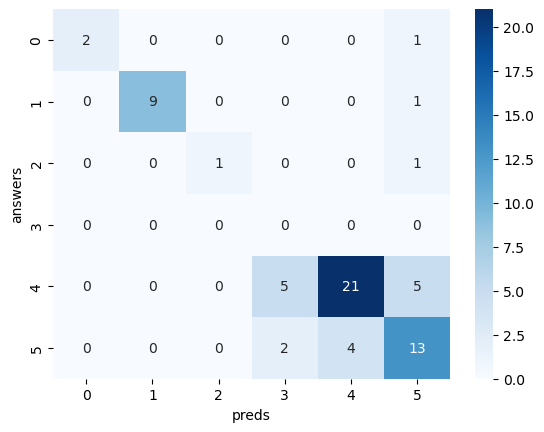

In [96]:
# p-value 산출
## z value : 회귀계수 / 표준오차 
## 1-normal cdf(abs(z))
from sklearn.metrics import confusion_matrix, accuracy_score

mlog_probas = mlog_model.predict(X_test)
mlog_preds= mlog_probas.idxmax(axis=1)

sns.heatmap(confusion_matrix(mlog_preds, y_test), annot=True, cmap="Blues");
plt.xlabel("preds");
plt.ylabel("answers");
print(accuracy_score(mlog_preds, y_test))

In [140]:
acc = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)
    mlog_model = sm.MNLogit(y_train, X_train).fit(method='bfgs', disp=False)
    mlog_probas = mlog_model.predict(X_test)
    mlog_preds= mlog_probas.idxmax(axis=1)
    acc.append(accuracy_score(mlog_preds, y_test))
np.mean(acc)

0.5869230769230769

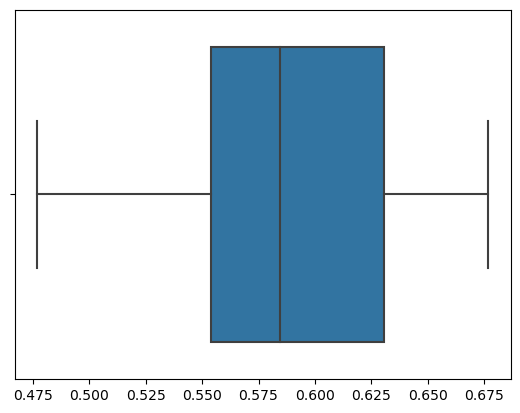

In [141]:
sns.boxplot(acc);

## 8.6 포아송 회귀분석
- 결과변수가 특정 기간 동안의 사건발생횟수(개수)인 경우에 적용
    - 제한된 값, 음수 불가능
- 포아송 회귀모델
$$ ln(\lambda) = \beta_0 + \beta_1x_1 + \dots + \beta_mx_m \\ \lambda=y_{mean}$$
    - 링크함수 $ln(\lambda)$, 결과변수 y의 확률분포는 포아송 분포

https://omarfsosa.github.io/poisson_regression_in_python#fn:1

In [215]:
url = "http://www.stat.columbia.edu/~gelman/arm/examples/police/frisk_with_noise.dat"
df = pd.read_csv(url, skiprows=6, delimiter=" ")

X = (df
     .groupby(['eth', 'precinct'])[['stops', 'past.arrests']]
     .sum()
     .reset_index()
     .pipe(pd.get_dummies, columns=['eth', 'precinct'])
     .assign(intercept=1)
)

y = X[['stops']]

# poi_model = sm.GLM(y, X.drop(['stops'], axis=1), offset=np.log(X['past.arrests']), family=sm.families.Poisson()).fit()
poi_model = sm.GLM(y, X.drop(columns=['eth_1', 'precinct_1', 'past.arrests']), offset=np.log(X['past.arrests']), family=sm.families.Poisson()).fit()
poi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  stops   No. Observations:                  225
Model:                            GLM   Df Residuals:                      147
Model Family:                 Poisson   Df Model:                           77
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2187.3
Date:                Sun, 01 Dec 2024   Deviance:                       2668.0
Time:                        18:00:55   Pearson chi2:                 2.64e+03
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
stops           0.0002   6.83e-06     26.835      0.000       0.000       0.000
eth_2           0.0556      0.007      7.738      0.000       0.041       0.070
eth_3          -0.2940      0.011    -27.666      0.000      -0.315      -0.273
precinct_2     -0.1512      0.074     -2.042      0.041      -0.296      -0.006
precinct_3      0.4697      0.057      8.262      0.000       0.358       0.581
precinct_4      1.1090      0.058     19.226      0.000       0.996       1.222
precinct_5      0.1879      0.057      3.302      0.001       0.076       0.299
precinct_6      1.0763      0.058     18.525      0.000       0.962       1.190
precinct_7      0.1939      0.064      3.014      0.003       0.068       0.320
precinct_8     -0.4874      0.057     -8.553      0.000      -0.599      -0.376
precinct_9      0.4816      0.078      6.162      0.000       0.328       0.635
precinct_10     0.3565      0.059      6.053      0.000       0.241       0.472
precinct_11     0.6114      0.062      9.924      0.000       0.491       0.732
precinct_12     1.1119      0.061     18.204      0.000       0.992       1.232
precinct_13     0.8980      0.056     16.164      0.000       0.789       1.007
precinct_14     0.5549      0.059      9.430      0.000       0.440       0.670
precinct_15     0.8854      0.055     16.006      0.000       0.777       0.994
precinct_16     0.7420      0.060     12.299      0.000       0.624       0.860
precinct_17    -0.1325      0.061     -2.188      0.029      -0.251      -0.014
precinct_18    -0.0278      0.055     -0.503      0.615      -0.136       0.081
precinct_19     0.1756      0.058      3.015      0.003       0.061       0.290
precinct_20    -0.1494      0.057     -2.617      0.009      -0.261      -0.037
precinct_21     0.2548      0.057      4.461      0.000       0.143       0.367
precinct_22     0.8833      0.055     16.118      0.000       0.776       0.991
precinct_23     0.4229      0.055      7.623      0.000       0.314       0.532
precinct_24     1.1087      0.055     20.097      0.000       1.001       1.217
precinct_25     0.6290      0.055     11.512      0.000       0.522       0.736
precinct_26    -0.2492      0.057     -4.362      0.000      -0.361      -0.137
precinct_27     1.7849      0.056     31.978      0.000       1.675       1.894
precinct_28    -0.8127      0.061    -13.334      0.000      -0.932      -0.693
precinct_29     0.8024      0.056     14.420      0.000       0.693       0.912
precinct_30     0.3689      0.056      6.625      0.000       0.260       0.478
precinct_31     1.5449      0.056     27.439      0.000       1.435       1.655
precinct_32     1.3282      0.060     22.241      0.000       1.211       1.445
precinct_33     0.8620      0.055     15.712      0.000       0.754       0.970
precinct_34     1.3416      0.055     24.50

In [218]:
# 회귀모델 유의성 검증
## null 모델 deviance가 모델을 통해 구축한 residual deviance 간의 차이가 통계적으로 유의미한지 확인
## 이탈도를 chi2분포하에서 검정
print(poi_model.deviance, poi_model.null_deviance)
print(stats.chi2.cdf(poi_model.null_deviance-poi_model.deviance, df=poi_model.df_model))

2668.0213443050934 46120.262572145395
1.0


In [219]:
np.exp(poi_model.params)

stops          1.000183
eth_2          1.057133
eth_3          0.745243
precinct_2     0.859694
precinct_3     1.599565
                 ...   
precinct_72    3.096102
precinct_73    1.975268
precinct_74    2.747456
precinct_75    4.404948
intercept      0.237236
Length: 78, dtype: float64

- 포아송회귀분석 : 평균과 분석이 같음
- 과산포문제 : 결과변수 관측된 분산이 기대분산보다 더 클 떄 발생 => 분산 : 평균 비율 > 1 경우
    - 표준오차가 매우 작아짐 -> 회귀계수 유의성 검증을 위해 사용하는 검정통계량 t값이 표준오차로 나눠 계산 -> 귀무가설 쉽게 기각
    - 상태의존성 : 포아송 가정(각 사건의 독립적이고 사건발생률이 일정) 위반 -> 잔차 자유도와 잔차 이탈도 비율이 크게 상회하면 과산포 의심
  $$ R = \frac{1}{n-k}\sum^n_i z^2_i \quad\quad z_i:\ standardized\ residuals=\frac{y_i-\mu}{\sigma}$$
    - R이 1과 비슷할 경우, 카이제곱 분포 비슷, 1보다 작을 경우 underdispersed.
- 과산포일 경우, 산포 parameter $\alpha$가 있는 negative binomial 분포 이용

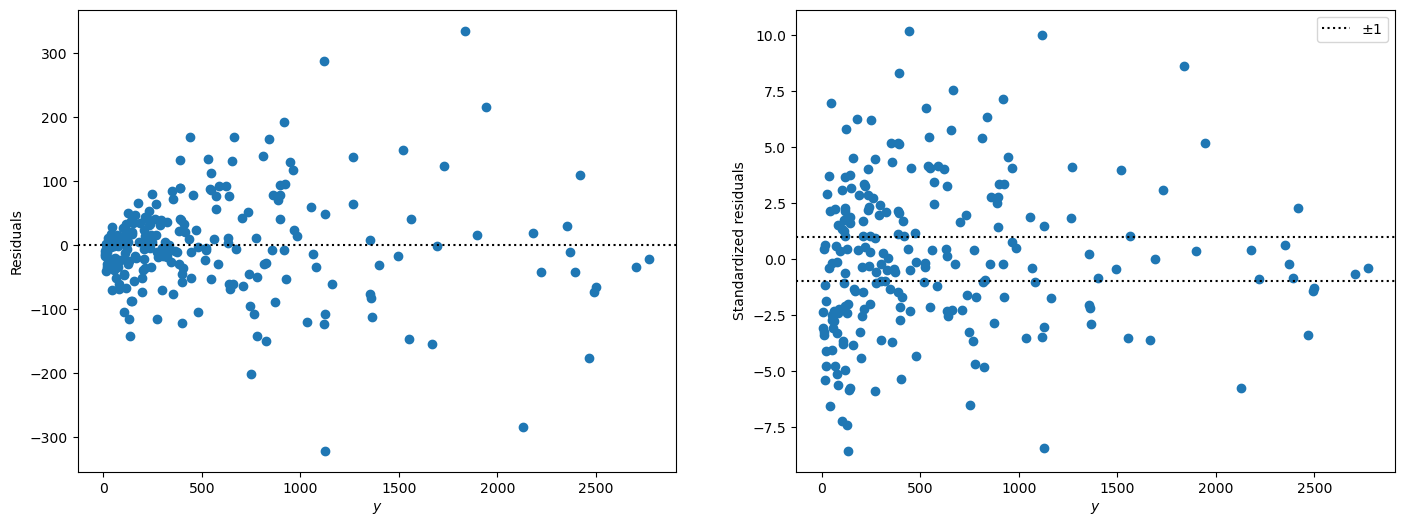

In [220]:
# 과산포 비율 계산
# 분산이 커지고, 95%의 표준화 잔차가 +-1 사이에 있지 않음
f, axes = plt.subplots(1, 2, figsize=(17, 6))
axes[0].plot(y, poi_model.resid_response, 'o')
axes[0].axhline(y=0, linestyle=':', color='black')
axes[0].set_ylabel("Residuals")
axes[0].set_xlabel("$y$")
axes[1].plot(y, poi_model.resid_pearson, 'o')
axes[1].axhline(y=-1, linestyle=':', color='black', label='$\pm 1$')
axes[1].axhline(y=+1, linestyle=':', color='black')
axes[1].set_ylabel("Standardized residuals")
axes[1].set_xlabel("$y$")
plt.legend()
plt.show()

In [228]:
# 과산포 수치화
R = np.sum(poi_model.resid_pearson**2) / poi_model.df_resid
print(R)  # 21.88

17.927903218958917


In [229]:
alpha = 0.05

nb_model = sm.GLM(y, X.drop(columns=['eth_1', 'precinct_1', 'past.arrests']), offset=np.log(X['past.arrests']), family=sm.families.NegativeBinomial(alpha=alpha)).fit()
nb_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  stops   No. Observations:                  225
Model:                            GLM   Df Residuals:                      147
Model Family:        NegativeBinomial   Df Model:                           77
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1276.3
Date:                Sun, 01 Dec 2024   Deviance:                       196.41
Time:                        18:13:47   Pearson chi2:                     192.
No. Iterations:                    10   Pseudo R-squ. (CS):             0.9994
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
stops           0.0002   3.44e-05      7.243      0.000       0.000       0.000
eth_2           0.0937      0.039      2.376      0.018       0.016       0.171
eth_3          -0.3163      0.046     -6.917      0.000      -0.406      -0.227
precinct_2     -0.2344      0.199     -1.178      0.239      -0.624       0.156
precinct_3      0.4837      0.193      2.503      0.012       0.105       0.862
precinct_4      0.8745      0.194      4.509      0.000       0.494       1.255
precinct_5      0.0054      0.193      0.028      0.978      -0.373       0.384
precinct_6      0.9584      0.194      4.949      0.000       0.579       1.338
precinct_7      0.1104      0.195      0.565      0.572      -0.272       0.493
precinct_8     -0.5455      0.194     -2.813      0.005      -0.926      -0.165
precinct_9      0.3448      0.201      1.719      0.086      -0.048       0.738
precinct_10     0.1794      0.194      0.925      0.355      -0.201       0.559
precinct_11     0.4819      0.194      2.482      0.013       0.101       0.863
precinct_12     1.0534      0.194      5.424      0.000       0.673       1.434
precinct_13     0.6842      0.196      3.499      0.000       0.301       1.068
precinct_14     0.4750      0.195      2.434      0.015       0.092       0.857
precinct_15     0.8350      0.195      4.280      0.000       0.453       1.217
precinct_16     0.6780      0.198      3.417      0.001       0.289       1.067
precinct_17     0.0646      0.203      0.319      0.750      -0.333       0.462
precinct_18    -0.0240      0.196     -0.123      0.902      -0.408       0.360
precinct_19     0.3767      0.204      1.844      0.065      -0.024       0.777
precinct_20    -0.3988      0.194     -2.058      0.040      -0.779      -0.019
precinct_21    -0.0647      0.195     -0.332      0.740      -0.446       0.317
precinct_22     0.5818      0.199      2.923      0.003       0.192       0.972
precinct_23     0.2076      0.194      1.068      0.286      -0.173       0.589
precinct_24     0.7389      0.199      3.711      0.000       0.349       1.129
precinct_25     0.3084      0.198      1.560      0.119      -0.079       0.696
precinct_26    -0.4726      0.200     -2.363      0.018      -0.865      -0.081
precinct_27     1.6726      0.193      8.660      0.000       1.294       2.051
precinct_28    -1.0774      0.201     -5.356      0.000      -1.472      -0.683
precinct_29     0.6316      0.196      3.218      0.001       0.247       1.016
precinct_30     0.1813      0.195      0.928      0.353      -0.202       0.564
precinct_31     1.4335      0.193      7.418      0.000       1.055       1.812
precinct_32     1.1564      0.194      5.948      0.000       0.775       1.538
precinct_33     0.7219      0.195      3.698      0.000       0.339       1.105
precinct_34     1.1520      0.194      5.93

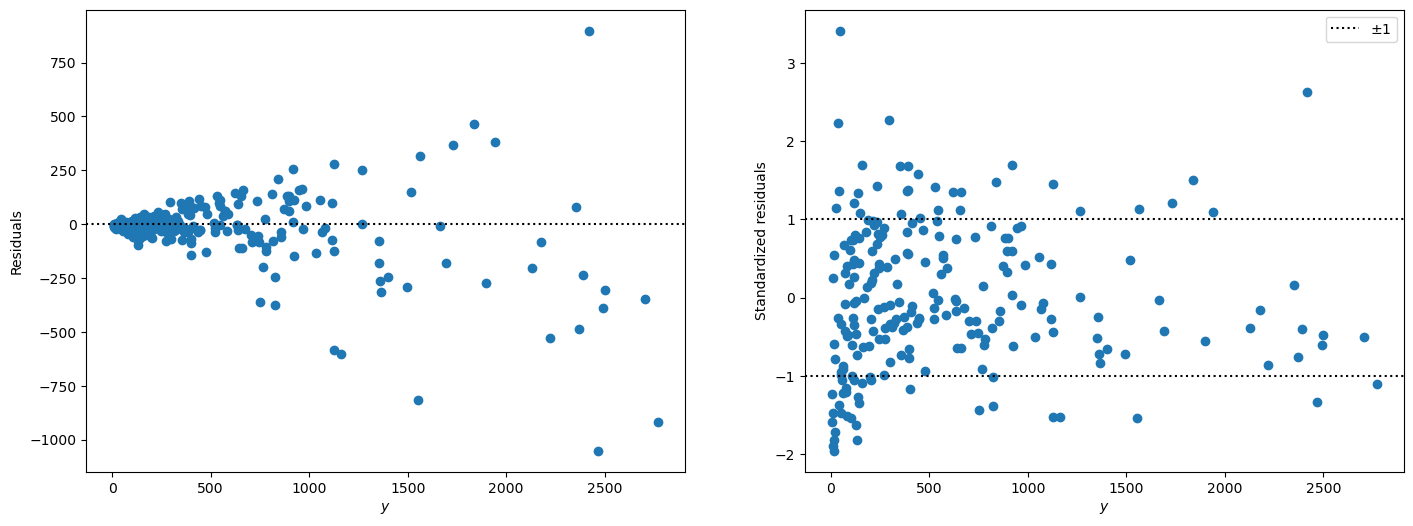

In [230]:
f, axes = plt.subplots(1, 2, figsize=(17, 6))
axes[0].plot(y, nb_model.resid_response, 'o')
axes[0].axhline(y=0, linestyle=':', color='black')
axes[0].set_ylabel("Residuals")
axes[0].set_xlabel("$y$")
axes[1].plot(y, nb_model.resid_pearson, 'o')
axes[1].axhline(y=-1, linestyle=':', color='black', label='$\pm 1$')
axes[1].axhline(y=+1, linestyle=':', color='black')
axes[1].set_ylabel("Standardized residuals")
axes[1].set_xlabel("$y$")
plt.legend()
plt.show()